### KDSB Dataset Preparation

In [1]:
%run ../kdsb_io.py

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvutils import visualize

data_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'stage1_train')
meta_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'stage1_meta')
result_dir = osp.join(os.environ['CODEX_DATA_DIR'], 'modeling', 'cytopy', 'datasets', 'kdsb2018', 'prep')

In [3]:
df = get_image_metadata(osp.join(meta_dir, 'classes.csv'), data_dir)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 13 columns):
filename      735 non-null object
foreground    735 non-null object
background    735 non-null object
fileid        735 non-null object
localdir      735 non-null object
localpath     735 non-null object
exists        735 non-null bool
nmasks        670 non-null float64
ndim          670 non-null float64
height        670 non-null float64
width         670 non-null float64
channels      670 non-null float64
dtype         670 non-null object
dtypes: bool(1), float64(5), object(7)
memory usage: 69.7+ KB


In [4]:
df.groupby(['foreground', 'background']).size()

foreground  background
black       white          16
purple      purple         71
            white          41
            yellow          8
white       black         599
dtype: int64

In [5]:
df_train = df.copy()

In [6]:
# Restrict to black/white images
df_train = df_train[(df_train['foreground'] == 'white') & (df_train['background'] == 'black')]
len(df_train), len(df)

(599, 735)

In [7]:
# Further restrict to those present in data dir
df_train = df_train[df_train['exists']].copy()
df_train['index'] = np.arange(len(df_train))
len(df_train), len(df)

(546, 735)

## Load Image Data

In [8]:
# This generally takes ~10 minutes

# Version 1
I, X, Y, class_names = load_images(data_dir, (256, 256, 1), ids=df_train['fileid'].tolist(), resize_mode='crop')

# Version 2
#I, X, Y, class_names = load_images(data_dir, (256, 256, 1), ids=df_train['fileid'].tolist(), resize_mode='rescale')

100%|██████████| 546/546 [15:16<00:00,  1.68s/it]
/usr/local/lib/python3.5/dist-packages/skimage/exposure/exposure.py:297: RuntimeWarning: invalid value encountered in true_divide
  image = (image - imin) / float(imax - imin)


In [9]:
def display(idx, size, classes=class_names, cols=None):
    if cols is None:
        cols = len(class_names) + 1
    images = []
    for i in idx:
        images.append(X[i, ..., 0])
        for c in range(Y.shape[-1]):
            images.append(Y[i, ..., c])
    visualize.display_images(images, size=size, cols=cols)

In [10]:
X.dtype, X.shape, Y.dtype, Y.shape

(dtype('uint8'), (1752, 256, 256, 1), dtype('bool'), (1752, 256, 256, 5))

In [11]:
class_names

['bg', 'nuc_interior', 'nuc_boundary', 'nuc_partition', 'nuc_center']

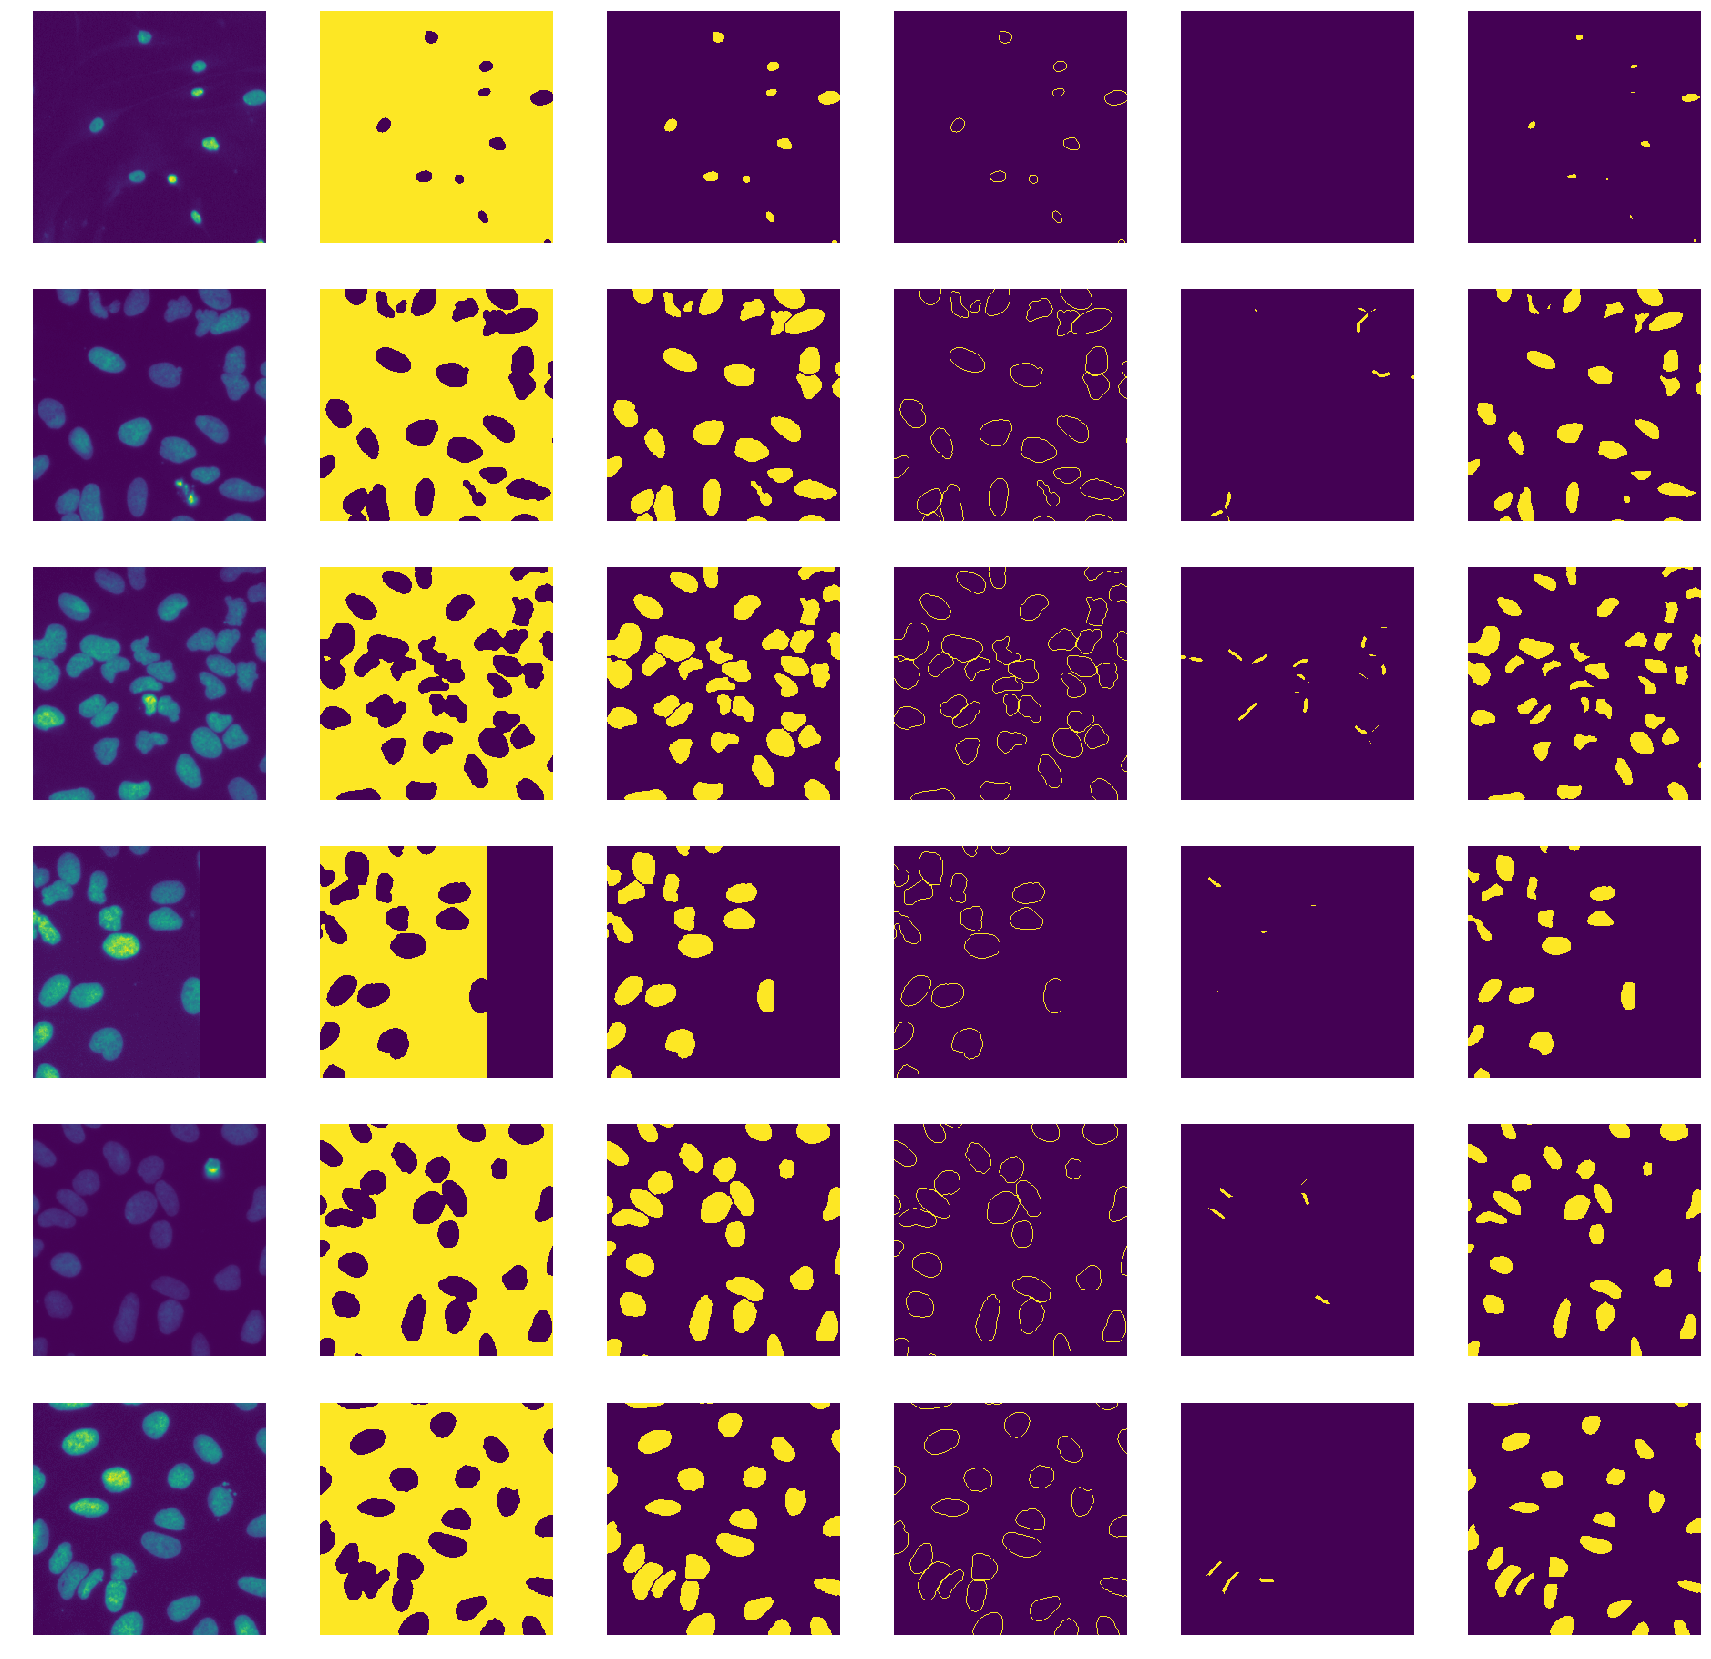

In [12]:
display([0, 1, 2, 3, 4, 5], 30)

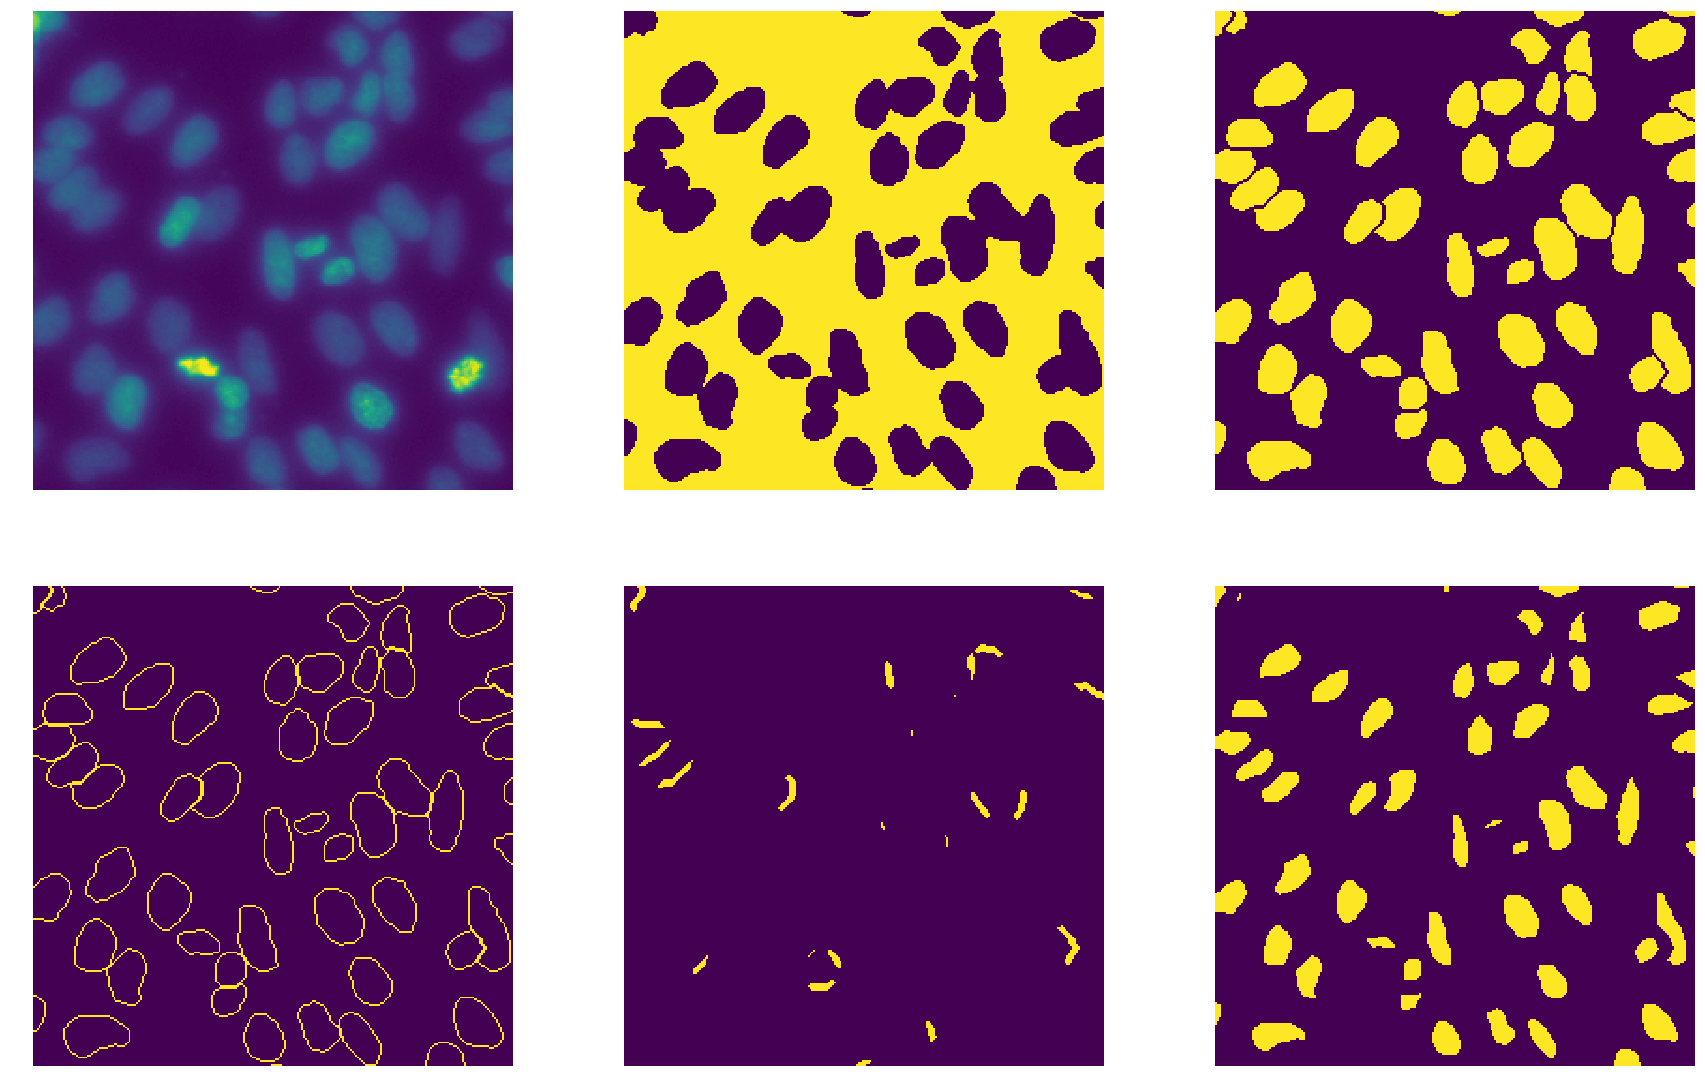

In [13]:
idx = np.argwhere(I == '5afb7932e9c7328f4fb1d7a8166a3699d6cdc5192b93758a75e9956f1513c5a3').ravel()
display(idx[:1], 30, cols=3)

### Export

In [14]:
import pickle

#exp_path = osp.join(result_dir, 'training_data_01.pkl')
#exp_path = osp.join(result_dir, 'training_data_02.pkl')
exp_path = osp.join(result_dir, 'training_data_03.pkl')
exp = dict(
    meta=df_train,
    index=I,
    X=X,
    Y=Y,
    class_names=class_names
)
os.makedirs(osp.dirname(exp_path), exist_ok=True)
with open(exp_path, 'wb') as fd:
    pickle.dump(exp, fd)
exp_path

'/lab/data/modeling/cytopy/datasets/kdsb2018/prep/training_data_03.pkl'